# EDA & Data Visualization
Because there are so many features in our loaning dataset, it's important to explore associations between them and identify the most significant factors contributing to default. In this notebook, univariate, bivariate, and multivariate analysis will be performed to understand the data better to build the model. 

### Imports

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../src/visualization") # access custom files

# import custom files
import plots

import os 
print(os.listdir("../data/LendingClub/processed"))

['Processed.csv']


### Loading and Inspecting Data
We have already cleaned parts of the raw data from LendingClub in the previous notebook, *Preprocessing.ipynb*, and we will use this version to create plots and look for interesting details about certain features. Some attributes like the loan *id*, and other unique features aren't very useful to inspect so they will be dropped from analysis.

In [5]:
processed_path = "../data/LendingClub/processed/Processed.csv"
data = pd.read_csv(processed_path)
print("Rows: " + str(data.shape[0]) + "  Columns: " + str(data.shape[1]))
data.head()

Rows: 143019  Columns: 108


,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,0,159170615,16000.0,16000.0,16000.0,36 months,17.74,576.36,2,14,...,100.0,50.0,0.0,0.0,33853.0,26947.0,5500.0,28353.0,N,N
1,1,159210254,10000.0,10000.0,10000.0,60 months,15.24,239.17,2,11,...,100.0,0.0,0.0,0.0,56504.0,29835.0,17800.0,35704.0,N,N
2,2,159226028,15000.0,15000.0,15000.0,60 months,14.30,351.37,2,10,...,91.4,33.3,0.0,0.0,301623.0,95559.0,45500.0,99724.0,N,N
3,3,159328733,24000.0,24000.0,24000.0,36 months,10.33,778.14,1,5,...,90.9,0.0,0.0,0.0,383103.0,154703.0,27600.0,149226.0,N,N
4,4,159374118,15000.0,15000.0,15000.0,36 months,11.02,491.23,1,6,...,85.7,20.0,0.0,0.0,440587.0,65451.0,22600.0,54887.0,N,N


In [3]:
data.columns

Index(['Unnamed: 0', 'id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies',
       'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'hardship_flag', 'debt_settlement_flag'],
      dtype='object', length=108)

### Loan Status
We should first explore the label we are trying to predict, which is the loan status detailing whether the loan is current, has been paid, is late, or has been charged off (default). Previously, we had encoded these categories into numerical values. The dictionary of encoding is referenced below, and we can see our data contains loans that fall into all of these categories.

In [17]:
status_dict = {0: "Charged Off", 1: "Current", 2: "Fully Paid", 3: "In Grace Period", 4: "Late (16-30 days)",
               5: "Late (31-120 days)"}

set(data["loan_status"])

{0, 1, 2, 3, 4, 5}

(0, 148322.90000000002)

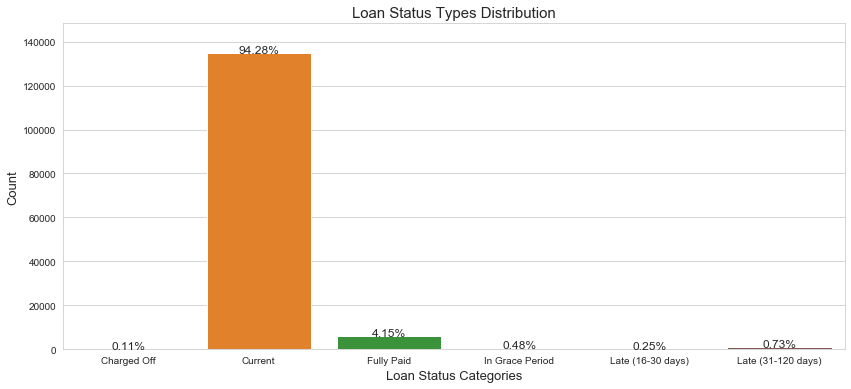

In [28]:
plt.figure(figsize=(14, 6))

g = sns.countplot(x="loan_status", data=data)
g.set_xticklabels(status_dict.values())
g.set_xlabel("Loan Status Categories", fontsize=13)
g.set_ylabel("Count", fontsize=13)
g.set_title("Loan Status Types Distribution", fontsize=15)

proportions = []
for status in g.patches:
    height = status.get_height()
    proportions.append(height)
    g.text(status.get_x()+status.get_width()/2.,
            height + 3,
            "{:1.2f}%".format(height/len(data)*100),
            ha="center", fontsize=12) 

g.set_ylim(0, max(sizes)*1.1)

### Loan Amount

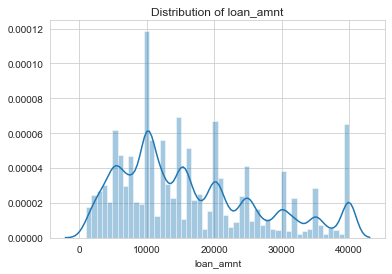

In [6]:
plots.histogram("loan_amnt", data)

In [ ]:
plots.barplot(data, "grade", "loan_amnt")

In [ ]:
plots.barplot(data, "grade", "loan_amnt", hue="sub_grade")

In [ ]:
plt.figure()
fig = plt.gcf() #creates the plot figure object
fig.set_size_inches(10, 10) #sets the plot size
plt.subplot(2, 2, 1) #first subplot, 2 rows and 2 columns
sns.distplot(df["Age"], bins=[15, 20, 25, 30, 35, 40, 45], kde=False, norm_hist=False) #make plot
plt.subplot(2, 2, 2) #second subplot, 2 rows and 2 columns
sns.distplot(df["Potential"], kde=False, norm_hist=False) #make plot
plt.subplots_adjust(left=0) #shift to make plots legible